<a href="https://colab.research.google.com/github/chandan2294/Time-Series-with-Deep-Learning-/blob/master/7.%20LSTM_for_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0-rc3


In [0]:
def plot_series(time, series, format = '-', start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

def trend(time, slope = 0):
  return time*slope

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4, 
                  np.cos(season_time * 2 * np.pi),
                  1/np.exp(3*season_time))
  
def seasonality(time, period, amplitude = 1, phase = 0):
  season_time = ((time + phase)%period)/period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

time = np.arange(4*365+1, dtype = 'float32')
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

#Create the series
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

#Update with noise
series += noise(time, noise_level, seed = 42)

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [0]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

**LSTM**

RNNs had cells that took patches as inputs (or X), and they calculated a (Y) output as well as the state vector (H), that fed into the cell along with the next X which then resulted in the Y, and the state vector and so on. The impact of this is that while state is a factor in subsequent calculations, its impacts can diminish greatly over timestamps. 

LSTMs are the cell state to this that keep a state throughout the life of the training so that the state is passed from cell to cell, timestamp to timestamp, and it can be better maintained. This means that the data from earlier in the window can have a greater impact on the overall projection than in the case of RNNs. The state can also be bidirectional so that state moves forwards and backwards. In the case of texts, this was really powerful. Within the prediction of numeric sequences, it may or may not be, and it'll be interesting to experiment with.

In [0]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                               input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x* 100.0)
])

In [10]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9, nesterov=True)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])

history = model.fit(dataset, epochs = 100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 25ms/step - loss: 21.4704 - mae: 22.0037 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 23ms/step - loss: 21.1542 - mae: 21.6328 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 24ms/step - loss: 20.7946 - mae: 21.2117 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 24ms/step - loss: 20.2719 - mae: 20.7624 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 25ms/step - loss: 19.7268 - mae: 20.2694 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 24ms/step - loss: 19.1397 - mae: 19.6443 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 24ms/step - loss: 18.2343 - mae: 18.6833 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 24ms/step - loss: 17.4344 - mae: 17.9657 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 24ms/step - loss: 17.1252 - mae:

(1e-08, 0.001, 0.0, 30.0)

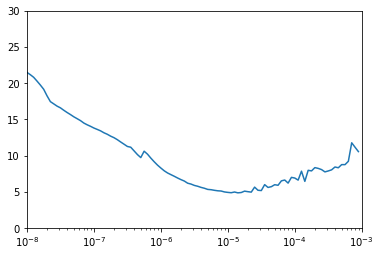

In [12]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 30])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(52)
np.random.seed(52)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis = -1),
                               input_shape = [None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*100.0)            
])

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum=0.9, nesterov=True),
              metrics = ['mae'])

history = model.fit(dataset, epochs = 500, verbose = 0)

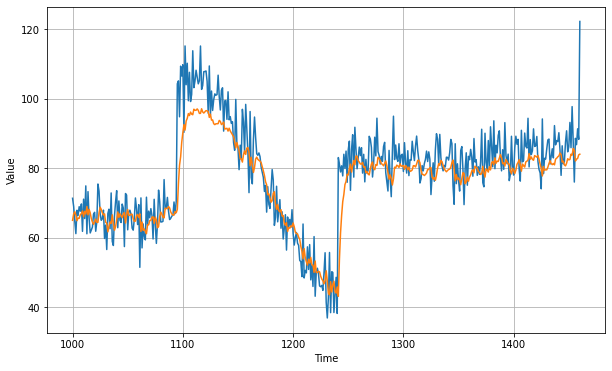

In [27]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.5419254

<Figure size 432x288 with 0 Axes>

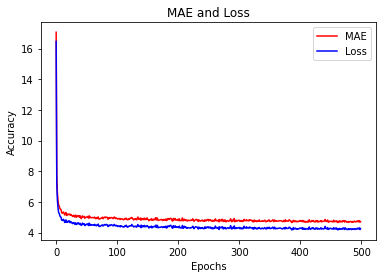

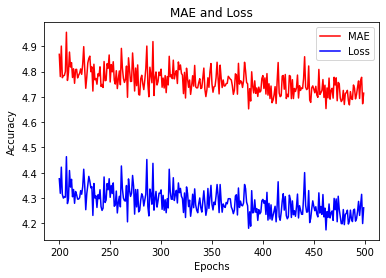

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss)) 

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(['MAE', 'Loss'])

plt.figure()

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])
plt.figure()